<a href="https://colab.research.google.com/github/geun-hyoung/StockPredictionByTextMining/blob/main/stock_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting

In [38]:
# 주가 데이터 참고 하실 때 좋으실거 같아서 첨부합니다.
# https://inhovation97.tistory.com/54 : 데이터 EDA & 예측 모델
# https://dacon.io/codeshare/2588 :
# https://unfinishedgod.netlify.app/2023/10/10/python-plotly-1/ : 시각화 참고 자료

In [ ]:
# Library Install, 오류 무시

!pip install yfinance
!pip install -U pandas-profiling

In [31]:
# Library Import

%matplotlib inline

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pandas as pd
import numpy as np
import ydata_profiling
import matplotlib.pyplot as plt

import yfinance as yf

from datetime import datetime, timedelta
from time import sleep
import time
import os

## EDA

In [30]:
# Data load - 테슬라 3년치 20년~22년 주가 데이터, 19년도 마지막날은 추후 비율을 구하기 위함 - 나중에 제거 요소
tsla_df = yf.download('TSLA', start='2019-12-31', end='2022-12-31')
tsla_df.profile_report()

[*********************100%%**********************]  1 of 1 completed


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
# 위의 profile 에 이미 존재
tsla_df.info()
tsla_df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2020-01-02 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       756 non-null    float64
 1   High       756 non-null    float64
 2   Low        756 non-null    float64
 3   Close      756 non-null    float64
 4   Adj Close  756 non-null    float64
 5   Volume     756 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 41.3 KB


Open        High         Low       Close   Adj Close  \
count  756.000000  756.000000  756.000000  756.000000  756.000000   
mean   206.595133  211.409117  201.220929  206.365502  206.365502   
std     96.049388   98.052777   93.701484   95.856975   95.856975   
min     24.980000   26.990667   23.367332   24.081333   24.081333   
25%    138.633339  141.930000  135.544170  138.270828  138.270828   
50%    223.964996  229.250000  218.174995  223.651665  223.651665   
75%    278.281670  283.412506  270.410828  276.565002  276.565002   
max    411.470001  414.496674  405.666656  409.970001  409.970001   

             Volume  
count  7.560000e+02  
mean   1.318622e+08  
std    1.001327e+08  
min    2.940180e+07  
25%    6.890498e+07  
50%    9.439035e+07  
75%    1.577763e+08  
max    9.140820e+08

### 주식 보조지표 추가

In [41]:
# 해당 영업일의 거래 대금 = 거래량 * 종가 - 출처 링크 첨부
tsla_df['transaction_amount'] = tsla_df['Close'] * tsla_df['Volume']
tsla_df.head()

Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2019-12-31  27.000000  28.086000  26.805332  27.888666  27.888666  154285500   
2020-01-02  28.299999  28.713333  28.114000  28.684000  28.684000  142981500   
2020-01-03  29.366667  30.266666  29.128000  29.534000  29.534000  266677500   
2020-01-06  29.364668  30.104000  29.333332  30.102667  30.102667  151995000   
2020-01-07  30.760000  31.441999  30.224001  31.270666  31.270666  268231500   

            Close_ratio  transaction_amount  
Date                                         
2019-12-31          NaN        4.302817e+09  
2020-01-02     0.028518        4.101281e+09  
2020-01-03     0.029633        7.876053e+09  
2020-01-06     0.019255        4.575455e+09  
2020-01-07     0.038801        8.387778e+09

In [42]:
# 해당 영업일의 거래 대금의 변동 비율(전일 대비)
tsla_df['transaction_ratio'] = tsla_df['transaction_amount'].pct_change()
tsla_df.head()

Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2019-12-31  27.000000  28.086000  26.805332  27.888666  27.888666  154285500   
2020-01-02  28.299999  28.713333  28.114000  28.684000  28.684000  142981500   
2020-01-03  29.366667  30.266666  29.128000  29.534000  29.534000  266677500   
2020-01-06  29.364668  30.104000  29.333332  30.102667  30.102667  151995000   
2020-01-07  30.760000  31.441999  30.224001  31.270666  31.270666  268231500   

            Close_ratio  transaction_amount  transaction_ratio  
Date                                                            
2019-12-31          NaN        4.302817e+09                NaN  
2020-01-02     0.028518        4.101281e+09          -0.046838  
2020-01-03     0.029633        7.876053e+09           0.920388  
2020-01-06     0.019255        4.575455e+09          -0.419068  
2020-01-07     0.038801        8.387778e+09           0.833212

In [43]:
# 해당 영업일의 종가 변동 비율(전일 대비)
tsla_df['Close_ratio'] = tsla_df['Close'].pct_change()
tsla_df.head()

Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2019-12-31  27.000000  28.086000  26.805332  27.888666  27.888666  154285500   
2020-01-02  28.299999  28.713333  28.114000  28.684000  28.684000  142981500   
2020-01-03  29.366667  30.266666  29.128000  29.534000  29.534000  266677500   
2020-01-06  29.364668  30.104000  29.333332  30.102667  30.102667  151995000   
2020-01-07  30.760000  31.441999  30.224001  31.270666  31.270666  268231500   

            Close_ratio  transaction_amount  transaction_ratio  
Date                                                            
2019-12-31          NaN        4.302817e+09                NaN  
2020-01-02     0.028518        4.101281e+09          -0.046838  
2020-01-03     0.029633        7.876053e+09           0.920388  
2020-01-06     0.019255        4.575455e+09          -0.419068  
2020-01-07     0.038801        8.387778e+09           0.833212

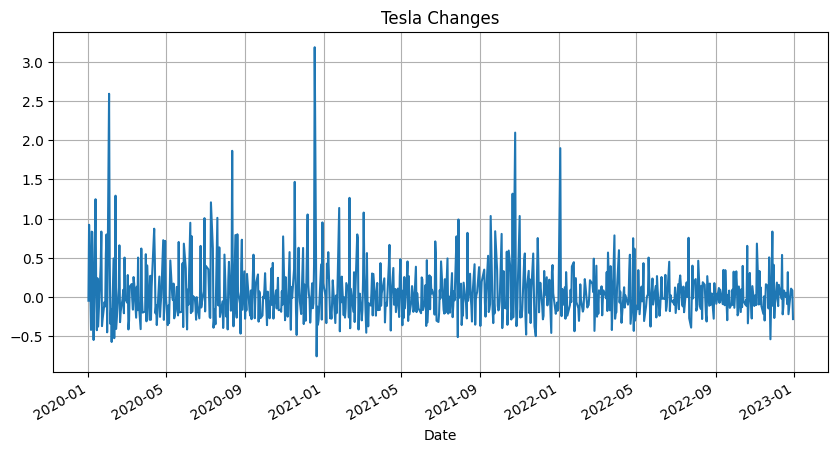

In [44]:
# 2021년 1월초(?), 주의점 : 유통 주식의 개수를 줄여 액면가의 변화가 생기면 가격 변동이 심함
tsla_df['transaction_ratio'].plot(figsize=(10, 5))
plt.title('Tesla Changes')
plt.grid(True)
plt.show()

In [46]:
# 이동평균, window = 이동평균 주기
tsla_df['MA20'] = tsla_df['Close'].rolling(window=20).mean()
tsla_df.head()

Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2019-12-31  27.000000  28.086000  26.805332  27.888666  27.888666  154285500   
2020-01-02  28.299999  28.713333  28.114000  28.684000  28.684000  142981500   
2020-01-03  29.366667  30.266666  29.128000  29.534000  29.534000  266677500   
2020-01-06  29.364668  30.104000  29.333332  30.102667  30.102667  151995000   
2020-01-07  30.760000  31.441999  30.224001  31.270666  31.270666  268231500   

            Close_ratio  transaction_amount  transaction_ratio  MA20  
Date                                                                  
2019-12-31          NaN        4.302817e+09                NaN   NaN  
2020-01-02     0.028518        4.101281e+09          -0.046838   NaN  
2020-01-03     0.029633        7.876053e+09           0.920388   NaN  
2020-01-06     0.019255        4.575455e+09          -0.419068   NaN  
2020-01-07     0.038801        8.387778e+09           0.833212   NaN

In [48]:
# 상대 강도 지수(RSI): 주식이 과매수 혹은 과매도 상태인지를 나타내는 지표
delta = tsla_df['Close'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down
tsla_df['RSI'] = 100 - (100/(1 + rs))
tsla_df.head()

Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2019-12-31  27.000000  28.086000  26.805332  27.888666  27.888666  154285500   
2020-01-02  28.299999  28.713333  28.114000  28.684000  28.684000  142981500   
2020-01-03  29.366667  30.266666  29.128000  29.534000  29.534000  266677500   
2020-01-06  29.364668  30.104000  29.333332  30.102667  30.102667  151995000   
2020-01-07  30.760000  31.441999  30.224001  31.270666  31.270666  268231500   

            Close_ratio  transaction_amount  transaction_ratio  MA20    RSI  
Date                                                                         
2019-12-31          NaN        4.302817e+09                NaN   NaN    NaN  
2020-01-02     0.028518        4.101281e+09          -0.046838   NaN  100.0  
2020-01-03     0.029633        7.876053e+09           0.920388   NaN  100.0  
2020-01-06     0.019255        4.575455e+09          -0.419068   NaN  100.0  
2020-01-07     0.038801        8.387778e+09           0.833212   NaN  100.0

In [50]:
returns = tsla_df['Close'].pct_change()
sp500 = yf.download('^GSPC', start='2019-01-01', end='2022-12-31')
sp500_returns = sp500['Close'].pct_change()
covariance = returns.cov(sp500_returns)
variance = sp500_returns.var()
beta = covariance / variance
print("Beta: ", beta)

[*********************100%%**********************]  1 of 1 completed
Beta:  1.7935632557593133


### 시각화

In [51]:
# 전반적인 차트 : PPT 채우기용으로 좋을거 같아서 한번 넣어봤습니다.
fig = go.Figure(
    data=go.Candlestick(
        x=tsla_df.index,
        open=tsla_df['Open'],
        high=tsla_df['High'],
        low=tsla_df['Low'],
        close=tsla_df['Close'],
        increasing_line_color= 'red', decreasing_line_color= 'blue')
)

# Rayout
fig.update_layout(

    # 제목
    title = 'Tesla Stock',
    title_font_family="맑은고딕",
    title_font_size = 18,

    # hover 배경
    hoverlabel=dict(
        bgcolor='black',
        font_size=15,
    ),

    # hover mode 변경
    hovermode="x unified",

    # 테마
    template='plotly_dark',

    # X축 각도
    xaxis_tickangle=90,

    # Y 축 포맷
    yaxis_tickformat = ',',

    # 범례
    legend = dict(orientation = 'h', xanchor = "center", x = 0.85, y= 1.1),

    barmode='group',

    # 여백
    margin=go.layout.Margin(
        l=10, #left margin
        r=10, #right margin
        b=10, #bottom margin
        t=50  #top margin
    ),

    # 길이
    height=600, width=800,

    showlegend=False,
    xaxis_rangeslider_visible=False
)

## 기존 예측 모델 : LSTM(RNN) 등

In [ ]:
# 보통 주가 예측에서는 Close 즉 종가를 많이 사용하는 것으로 식별 = 예측 변수로 지정
pred_y = tsla_df[['Close']]